In [1]:
# import libraries
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from category_encoders import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact

warnings.simplefilter(action="ignore", category=FutureWarning)

## Prepare Data

### Import

In [2]:
def wrangle(filepath):
    # read csv file
    df=pd.read_csv(filepath)
    
    # remove low cardinality
    df.drop(columns=['bus_ter'],inplace=True)
    
    # remove outliers in n_hot_rooms & rainfall
    low = df['rainfall'].quantile(0.1)
    mask_rainfall = df['rainfall'].between(low, df['rainfall'].max())
    
    high = df['n_hot_rooms'].quantile(0.9)
    mask_rooms = df['n_hot_rooms'].between(df['n_hot_rooms'].min(), high)

    df=df[mask_rooms & mask_rainfall]

    # variable transformation
    df['avg_dis']=(df['dist1']+df['dist2']+df['dist3']+df['dist4'])/4
    df.drop(columns=['dist1','dist2','dist3','dist4'],inplace=True)
    
    return df

In [3]:
df=wrangle('House_Price.csv')
df.head()

,price,resid_area,air_qual,room_num,age,teachers,poor_prop,airport,n_hos_beds,n_hot_rooms,waterbody,rainfall,parks,Sold,avg_dis
0,24.0,32.31,0.538,6.575,65.2,24.7,4.98,YES,5.480,11.1920,River,23,0.049347,0,4.0875
1,21.6,37.07,0.469,6.421,78.9,22.2,9.14,NO,7.332,12.1728,Lake,42,0.046146,1,4.9675
3,33.4,32.18,0.458,6.998,45.8,21.3,2.94,YES,9.268,11.2672,Lake,45,0.047151,0,6.0650
4,36.2,32.18,0.458,7.147,54.2,21.3,5.33,NO,8.824,11.2896,Lake,55,0.039474,0,6.0625
5,28.7,32.18,0.458,6.430,58.7,21.3,5.21,YES,7.174,14.2296,None,53,0.045910,1,6.0600


In [4]:
print(df.shape)
df.info()

(422, 15)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 422 entries, 0 to 505
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        422 non-null    float64
 1   resid_area   422 non-null    float64
 2   air_qual     422 non-null    float64
 3   room_num     422 non-null    float64
 4   age          422 non-null    float64
 5   teachers     422 non-null    float64
 6   poor_prop    422 non-null    float64
 7   airport      422 non-null    object 
 8   n_hos_beds   416 non-null    float64
 9   n_hot_rooms  422 non-null    float64
 10  waterbody    422 non-null    object 
 11  rainfall     422 non-null    int64  
 12  parks        422 non-null    float64
 13  Sold         422 non-null    int64  
 14  avg_dis      422 non-null    float64
dtypes: float64(11), int64(2), object(2)
memory usage: 52.8+ KB


### Explore

In [5]:
# missing values
df.isnull().sum()/len(df)

price          0.000000
resid_area     0.000000
air_qual       0.000000
room_num       0.000000
age            0.000000
teachers       0.000000
poor_prop      0.000000
airport        0.000000
n_hos_beds     0.014218
n_hot_rooms    0.000000
waterbody      0.000000
rainfall       0.000000
parks          0.000000
Sold           0.000000
avg_dis        0.000000
dtype: float64

In [6]:
df.select_dtypes('object').nunique()

airport      2
waterbody    4
dtype: int64

In [7]:
df.describe()

,price,resid_area,air_qual,room_num,age,teachers,poor_prop,n_hos_beds,n_hot_rooms,rainfall,parks,Sold,avg_dis
count,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,416.000000,422.000000,422.000000,422.000000,422.000000,422.000000
mean,21.846919,41.654147,0.561990,6.247384,70.832227,21.464455,13.247749,7.913582,12.480463,40.469194,0.055099,0.452607,3.719923
std,9.024018,6.955601,0.119163,0.705062,27.776848,2.140330,7.355683,1.510874,1.545135,11.731669,0.010759,0.498340,2.140696
min,5.000000,30.460000,0.385000,3.561000,2.900000,18.000000,1.730000,5.268000,10.057600,22.000000,0.033292,0.000000,1.127500
25%,16.025000,35.640000,0.453000,5.875500,48.625000,19.800000,7.280000,6.632000,11.166400,30.000000,0.046922,0.000000,1.991875
50%,20.550000,39.900000,0.538000,6.183500,81.650000,20.900000,12.335000,8.012000,12.206400,40.000000,0.054361,0.000000,3.078750
75%,24.800000,48.100000,0.647000,6.594500,95.000000,22.600000,17.600000,9.149000,14.112200,51.000000,0.061719,1.000000,5.113125
max,50.000000,57.740000,0.871000,8.780000,100.000000,27.400000,37.970000,10.876000,15.153600,60.000000,0.086711,1.000000,12.127500


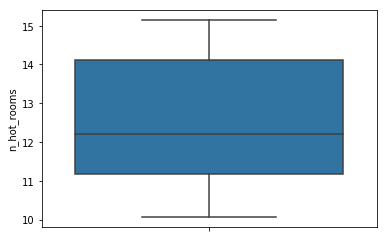

In [8]:
sns.boxplot(y='n_hot_rooms',data=df);

C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


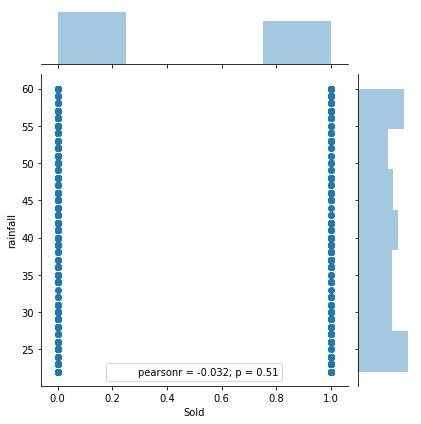

In [9]:
sns.jointplot(y='rainfall',x='Sold',data=df);

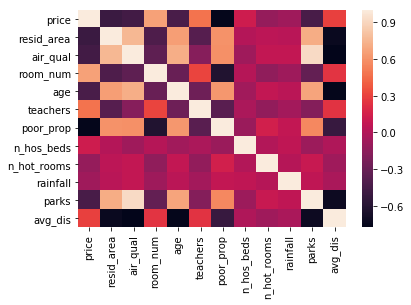

In [10]:
corr = df.select_dtypes('number').drop(columns='Sold').corr()
sns.heatmap(corr);

### Split Data

In [11]:
X=df.loc[:,df.columns!='Sold']
y=df['Sold']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

## Build Model

### Baseline Model

In [12]:
# baseline 
acc_baseline = y_train.value_counts(normalize=True).max()
print('Baseline Accuracy:', round(acc_baseline,2))

Baseline Accuracy: 0.55


### Iterate

In [13]:
model=make_pipeline(OneHotEncoder(use_cat_names=True),SimpleImputer(),LogisticRegression(max_iter=1000))
model.fit(X_train,y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['airport', 'waterbody'],
                               use_cat_names=True)),
                ('simpleimputer', SimpleImputer()),
                ('logisticregression', LogisticRegression(max_iter=1000))])

### Evalute

In [14]:
acc_train = model.score(X_train, y_train)
acc_test = model.score(X_test, y_test)
print('Training Accuracy:', round(acc_train, 2))
print('Test Accuracy:', round(acc_test, 2))

Training Accuracy: 0.69
Test Accuracy: 0.71


## Communicate Results

In [15]:
features = model.named_steps['onehotencoder'].get_feature_names_out()
importances = model.named_steps['logisticregression'].coef_[0]

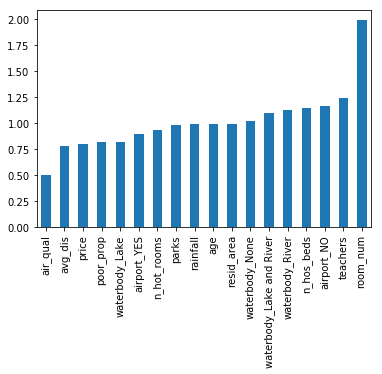

In [16]:
odds_ratio = pd.Series(np.exp(importances), index=features).sort_values()
odds_ratio.plot(kind='bar');

In [17]:
def make_prediction(age,air_qual,airport,avg_dis,n_hos_beds,n_hot_rooms,parks,poor_prop,price,rainfall,resid_area,room_num,teachers,waterbody):
    data={
        'age':age,
 'air_qual':air_qual,
 'airport': airport,
 'avg_dis':avg_dis,
 'n_hos_beds': n_hos_beds,
 'n_hot_rooms': n_hot_rooms,
 'parks': parks,
 'poor_prop': poor_prop,
 'price': price,
 'rainfall': rainfall,
 'resid_area': resid_area,
 'room_num':room_num,
 'teachers': teachers,
    'waterbody'  :waterbody,  
    }
    df=pd.DataFrame(data,index=[0])
    prediction = model.predict(df).round(2)[0]
    return f"Apartment will sell or not: {prediction}"

In [18]:
interact(
    make_prediction,
    rainfall=IntSlider(
        min=X_train["rainfall"].min(),
        max=X_train["rainfall"].max(),
        value=X_train["rainfall"].mean(),
    ),
    age=FloatSlider(
        min=X_train["age"].min(),
        max=X_train["age"].max(),
        step=0.01,
        value=X_train["age"].mean(),
    ),
    air_qual=FloatSlider(
        min=X_train["air_qual"].min(),
        max=X_train["air_qual"].max(),
        step=0.01,
        value=X_train["air_qual"].mean(),
    ),
    avg_dis=FloatSlider(
        min=X_train["avg_dis"].min(),
        max=X_train["avg_dis"].max(),
        step=0.01,
        value=X_train["avg_dis"].mean(),
    ),
    n_hos_beds=FloatSlider(
        min=X_train["n_hos_beds"].min(),
        max=X_train["n_hos_beds"].max(),
        step=0.01,
        value=X_train["n_hos_beds"].mean(),
    ),
    n_hot_rooms=FloatSlider(
        min=X_train["n_hot_rooms"].min(),
        max=X_train["n_hot_rooms"].max(),
        step=0.01,
        value=X_train["n_hot_rooms"].mean(),
    ),parks=FloatSlider(
        min=X_train["parks"].min(),
        max=X_train["parks"].max(),
        step=0.01,
        value=X_train["parks"].mean(),
    ),poor_prop=FloatSlider(
        min=X_train["poor_prop"].min(),
        max=X_train["poor_prop"].max(),
        step=0.01,
        value=X_train["poor_prop"].mean(),
    ),price=FloatSlider(
        min=X_train["price"].min(),
        max=X_train["price"].max(),
        step=0.01,
        value=X_train["price"].mean(),
    ),resid_area=FloatSlider(
        min=X_train["resid_area"].min(),
        max=X_train["resid_area"].max(),
        step=0.01,
        value=X_train["resid_area"].mean(),
    ),room_num=FloatSlider(
        min=X_train["room_num"].min(),
        max=X_train["room_num"].max(),
        step=0.01,
        value=X_train["room_num"].mean(),
    ),teachers=FloatSlider(
        min=X_train["teachers"].min(),
        max=X_train["teachers"].max(),
        step=0.01,
        value=X_train["teachers"].mean(),
    ),
    airport=Dropdown(options=sorted(X_train["airport"].unique())),
    waterbody=Dropdown(options=sorted(X_train["waterbody"].unique())),
);

interactive(children=(FloatSlider(value=71.41602373887245, description='age', min=2.9, step=0.01), FloatSlider…